### 1. Import the required libraries


In [1]:
# !pip install pathlib python_dotenv pandas

import os
import json
from pathlib import Path
from dotenv import load_dotenv

import pandas as pd

import warnings

warnings.filterwarnings("ignore")

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

curr_dir = Path.cwd()

### 2. Read, Process and Chunk the PDF Files


We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

#### 2.1 Reading a single PDF file and exploring it through pdfplumber

In [2]:
# !pip install pdfplumber pillow

import pdfplumber
from IPython.display import display
from PIL import Image

£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ
[1 , 2024 ]
THE CONSTITUTION OF INDIA
[As on 1st May, 2024]
2024
GOVERNMENT OF INDIA
MINISTRY OF LAW AND JUSTICE
LEGISLATIVE DEPARTMENT,OFFICIAL LANGUAGES WING
Saved: Image1_x285_y216.png


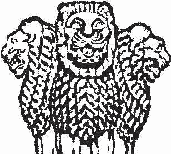

Saved: Image2_x285_y253.png


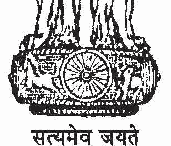

In [3]:
file_path = curr_dir / "data" / "Constitution_of_India.pdf"

# Open the PDF file
with pdfplumber.open(file_path) as pdf:
    # Get one of the pages from the PDF and examine it
    page = pdf.pages[0]

    # Extract Text from a page
    text = page.extract_text()
    print(text)

    # Extract Tables from a page
    tables = page.extract_tables()
    for table in tables:
        for row in table:
            print(row)

    # Extract Images from a page
    for idx, image in enumerate(page.images):
        # Organise images in output folders
        output_path = curr_dir / "data" / "images" / file_path.stem
        output_path.mkdir(parents=True, exist_ok=True)

        # Create bbox manually
        x0, top, x1, bottom = image["x0"], image["top"], image["x1"], image["bottom"]
        bbox = (x0, top, x1, bottom)

        # Crop and convert image region
        cropped_image = page.within_bbox(bbox).to_image(resolution=300)

        # Create a meaningful filename
        name_part = image.get("name", f"img{idx}")
        image_name = f"{name_part}_x{int(x0)}_y{int(top)}.png"
        cropped_image.save(output_path / image_name)
        print(f"Saved: {image_name}")

        # Display in notebook
        display(Image.open(output_path / image_name))

##### <font color= red> The Image is being printed as jargon.

In [ ]:
file_path = (
    curr_dir
    / "data"
    / "The_Goods_and_Services_Tax_(Compensation_to_States)_Act_2017.pdf"
)


# Open the PDF file

with pdfplumber.open(file_path) as pdf:

    # Get one of the pages from the PDF and examine it

    page = pdf.pages[7]


    # Extract Text from a page

    text = page.extract_text()
    print(text)


    # Extract Tables from a page

    tables = page.extract_tables()

    for table in tables:

        for row in table:

            print(row)


    # Extract Images from a page

    for idx, image in enumerate(page.images):

        # Organise images in output folders

        output_path = curr_dir / "data" / "images" / file_path.stem

        output_path.mkdir(parents=True, exist_ok=True)


        # Create bbox manually

        x0, top, x1, bottom = image["x0"], image["top"], image["x1"], image["bottom"]

        bbox = (x0, top, x1, bottom)


        # Crop and convert image region

        cropped_image = page.within_bbox(bbox).to_image(resolution=300)


        # Create a meaningful filename

        name_part = image.get("name", f"img{idx}")

        image_name = f"{name_part}_x{int(x0)}_y{int(top)}.png"

        cropped_image.save(output_path / image_name)

        print(f"Saved: {image_name}")


        # Display in notebook

        display(Image.open(output_path / image_name))

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


THE SCHEDULE
[See section 8 (2)]
1. In this Schedule, reference to a “tariff item”, “heading”, “sub-heading” and “Chapter”, wherever
they occur, shall mean respectively a tariff item, heading, sub-heading and Chapter in the First Schedule
to the Customs Tariff Act, 1975 (51 of 1975).
2. The rules for the interpretation of the First Schedule to the Customs Tariff Act, 1975 (51 of 1975),
the section and Chapter Notes and the General Explanatory Notes of the First Schedule shall, so far as
may be, apply to the interpretation of this Schedule.
S. No. Description of supply of goods or Tariff item, heading, The maximum rate at
services sub-heading, Chapter, or which goods and services
supply of goods or tax compensation cess
services, as the case may may be collected
be
(1) (2) (3) (4)
1. Pan Masala. 2106 90 20 1 [fifty-one per cent. of
retail sale price per unit]
2. Tobacco and manufactured tobacco 24 2 [Four thousand one
substitutes, including tobacco hundred and seventy
products. rupees p

##### <font color = red> The Text inside the table is chunked both as text as well as table leading to repetition.

#### 2.2 Extracting text from multiple PDFs


Let"s now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [5]:
from operator import itemgetter
from statistics import multimode


def is_inside_bbox(word, bboxes):
    """Check if a word is inside any excluded bbox (image/table)."""
    for x0, top, x1, bottom in bboxes:
        if x0 <= float(word["x0"]) <= x1 and top <= float(word["top"]) <= bottom:
            return True
    return False


def extract_text_from_pdf(file_path):
    full_text = []
    output_path = curr_dir / "data" / "images" / file_path.stem

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            page_no = page.page_number
            # print(f"Extracting Page No. {page_no}")
            page_no = f"Page {page.page_number}"

            # Extract Tables from a page
            tables = page.find_tables()
            tables = [
                {"table": table.extract(), "type": "table", "top": table.bbox[1]}
                for table in tables
            ]

            # Extract Images from a page
            images = []
            for idx, image in enumerate(page.images):
                # Organise images in output folders
                output_path = curr_dir / "data" / "images" / file_path.stem
                output_path.mkdir(parents=True, exist_ok=True)

                # Create bbox manually
                x0, top, x1, bottom = (
                    image["x0"],
                    image["top"],
                    image["x1"],
                    image["bottom"],
                )
                bbox = (x0, top, x1, bottom)

                # Crop and convert image region
                cropped_image = page.within_bbox(bbox).to_image(resolution=300)

                # Create a meaningful filename
                name_part = image.get("name", f"img{idx}")
                image_name = f"{name_part}_x{int(x0)}_y{int(top)}.png"
                image_path = output_path / image_name
                cropped_image.save(image_path)
                images.append({"image": str(image_path), "type": "image", "top": top})
                print(f"Saved: {image_name}")

            # Combine table + image bounding boxes
            image_bboxes = [
                (img["x0"], img["top"], img["x1"], img["bottom"]) for img in page.images
            ]
            table_bboxes = [table.bbox for table in page.find_tables()]
            exclude_bboxes = image_bboxes + table_bboxes

            # Extract and clean words
            words = page.extract_words(keep_blank_chars=True, use_text_flow=True)
            clean_words = [w for w in words if not is_inside_bbox(w, exclude_bboxes)]

            # Form lines
            line_clusters = pdfplumber.utils.cluster_objects(
                clean_words, itemgetter("top"), tolerance=5
            )
            lines = []
            for cluster in line_clusters:
                line_text = " ".join(w["text"] for w in cluster)
                if line_text.strip():
                    lines.append(
                        {"text": line_text, "type": "text", "top": cluster[0]["top"]}
                    )

            # Compute vertical gap threshold between paragraphs
            font_sizes = [float(w["size"]) for w in clean_words if "size" in w]
            modes = multimode(font_sizes)
            avg_font_size = min(modes) if modes else 12  # choose smallest mode
            gap_threshold = avg_font_size * 1.2

            # Group lines into Paragraphs
            paragraphs = []
            curr_para_top = lines[0]["top"]
            current_para = lines[0]["text"].strip()
            for i in range(1, len(lines)):
                prev = lines[i - 1]
                curr = lines[i]
                gap = curr["top"] - prev["top"]
                if gap > gap_threshold:
                    paragraphs.append(
                        {
                            "text": current_para.strip(),
                            "type": "text",
                            "top": curr_para_top,
                        }
                    )
                    current_para = curr["text"].strip()
                    curr_para_top = curr["top"]
                else:
                    current_para += " " + curr["text"].strip()
            if current_para:
                paragraphs.append(
                    {"text": current_para.strip(), "type": "text", "top": curr_para_top}
                )

            clusters = pdfplumber.utils.cluster_objects(
                paragraphs + tables + images, itemgetter("top"), tolerance=5
            )
            para_no = table_no = image_no = 0
            for cluster in clusters:
                if isinstance(cluster[0], dict) and "text" in cluster[0]:
                    para_no += 1
                    row = [
                        cluster[0]["type"],
                        cluster[0]["text"],
                        file_path.name,
                        page_no,
                        f"Paragraph {para_no}",
                    ]
                elif isinstance(cluster[0], dict) and "table" in cluster[0]:
                    table_no += 1
                    row = [
                        cluster[0]["type"],
                        json.dumps(cluster[0]["table"]),
                        file_path.name,
                        page_no,
                        f"Table {table_no}",
                    ]
                elif isinstance(cluster[0], dict) and "image" in cluster[0]:
                    image_no += 1
                    row = [
                        cluster[0]["type"],
                        cluster[0]["image"],
                        file_path.name,
                        page_no,
                        f"Table {image_no}",
                    ]
                full_text.append(row)

            # print(full_text)

    return full_text

In [ ]:
from IPython.utils import io

# Define the directory containing the PDF files
folder_path = curr_dir / "data"
file_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))
]
print("List of PDF files:")
for file in file_list:
    print(f"- {file}")
print("\n")

# Initialize an empty list to store the extracted texts and document names


data = []



# Loop through all files in the directory


for file_path in folder_path.glob("*.pdf"):


    # Process the PDF file


    print(f"...Processing {file_path.name}")


    # Call the function to extract the text from the PDF


    with io.capture_output():
        extracted_text = extract_text_from_pdf(file_path)


    # Convert the extracted list to a PDF, and add a column to store document names


    extracted_text_df = pd.DataFrame(
        extracted_text, columns=["Type", "Content", "Document Name", "Page No.", "S.No"]
    )


    # Append the extracted text and document name to the list
    data.append(extracted_text_df)


    # Print a message to indicate progress


    print(f"Finished processing {file_path.name}")



# Print a message to indicate all PDFs have been processed


print("All PDFs have been processed.")

List of PDF files:
- Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf
- Bharatiya_Nyaya_Sanhita_2023.pdf
- Bharatiya_Sakshya_Adhiniyam_2023.pdf
- Constitution_of_India.pdf
- Income_Tax_Act_1961.pdf
- The_Arms_Act_1959.pdf
- The_Central_Goods_and_Services_Tax_Act_2017.pdf
- The_Citizenship_Act_1955.pdf
- The_Code_of_Civil_Procedure_1908.pdf
- The_Delimitation_Act_2002.pdf
- The_Direct_Tax_Vivad_se_Vishwas_Act_2020.pdf
- The_Epidemic_Diseases_Act_1897.pdf
- The_Goods_and_Services_Tax_(Compensation_to_States)_Act_2017.pdf
- The_Indian_Contract_Act_1872.pdf
- The_Integrated_Goods_and_Services_Tax_Act_2017.pdf
- The_Limitation_Act_1963.pdf
- The_Police_Act_1949.pdf
- The_Prisoners_Act_1900.pdf
- The_Registration_Act_1908.pdf
- The_Representation_of_the_People_Act_1950.pdf
- The_Representation_of_the_People_Act_1951.pdf
- The_Right_to_Information_Act_2005.pdf
- The_Union_Territory_Goods_And_Services_Tax_Act_2017.pdf
- The_Unlawful_Activities_(Prevention)_Act_1967.pdf


...Processing Bharatiya_Nag

In [7]:
# Concatenate all the DFs in the list "data" together
indian_laws = pd.concat(data, ignore_index=True)
indian_laws

,Type,Content,Document Name,Page No.,S.No
0,text,"THE BHARATIYA NAGARIK SURAKSHA SANHITA, 2023",Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 1
1,text,_____________,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 2
2,text,ARRANGEMENT OF SECTIONS,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 3
3,text,__________,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 4
4,text,CHAPTER I PRELIMINARY,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 5
...,...,...,...,...,...
44103,text,"1. Ins. by notification No. S.O. 3819(E), date...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 31,Paragraph 1
44104,text,31,The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 31,Paragraph 2
44105,table,"[[""1[39."", ""Imtiyaz Ahmed Kandoo @ Sajad @Faya...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 32,Table 1
44106,text,"1. Ins. by Notification No. S.O. 4670(E), date...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 32,Paragraph 1


In [8]:
# Check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
indian_laws["Text_Length"] = indian_laws["Content"].apply(lambda x: len(x.split(" ")))
indian_laws["Text_Length"].value_counts()

Text_Length
1      3019
3      1928
2      1631
9      1421
6      1357
       ... 
529       1
380       1
694       1
530       1
191       1
Name: count, Length: 444, dtype: int64

In [9]:
# Retain only the rows with a text length of at least 10
indian_laws = indian_laws.loc[indian_laws["Text_Length"] >= 10]
indian_laws

,Type,Content,Document Name,Page No.,S.No,Text_Length
5,text,"SECTIONS 1. Short title, extent and commencem...",Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 6,40
6,text,6. Classes of Criminal Courts. 7. Territoria...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 7,75
9,text,21. Courts by which offences are triable. 22. ...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 10,67
12,text,POWERS OF SUPERIOR OFFICERS OF POLICE AND AID ...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 2,Paragraph 2,14
13,text,SECTIONS 30. Powers of superior officers of po...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 2,Paragraph 3,50
...,...,...,...,...,...,...
44100,text,"1. Added by Act 28 of 2019, s. 12 (w.e.f. 14-8...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 30,Paragraph 3,187
44102,table,"[[""1[17."", ""Shahid Mehmood @ Shahid Mehmood Re...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 31,Table 1,258
44103,text,"1. Ins. by notification No. S.O. 3819(E), date...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 31,Paragraph 1,242
44105,table,"[[""1[39."", ""Imtiyaz Ahmed Kandoo @ Sajad @Faya...",The_Unlawful_Activities_(Prevention)_Act_1967.pdf,Page 32,Table 1,150


In [10]:
# Check one of the extracted page texts to ensure that the text has been correctly read
indian_laws.Content[15]

'ARREST OF PERSONS 35. When police may arrest without warrant. 36. Procedure of arrest and duties of officer making arrest. 37. Designated police officer. 38. Right of arrested person to meet an advocate of his choice during interrogation. 39. Arrest on refusal to give name and residence. 40. Arrest by private person and procedure on such arrest. 41. Arrest by Magistrate. 42. Protection of members of Armed Forces from arrest. 43. Arrest how made. 44. Search of place entered by person sought to be arrested. 45. Pursuit of offenders into other jurisdictions. 46. No unnecessary restraint. 47. Person arrested to be informed of grounds of arrest and of right to bail. 48. Obligation of person making arrest to inform about arrest, etc., to relative or friend. 49. Search of arrested person. 50. Power to seize offensive weapons. 51. Examination of accused by medical practitioner at request of police officer. 52. Examination of person accused of rape by medical practitioner. 53. Examination of a

In [11]:
# Store the metadata for each page in a separate column
indian_laws["Metadata"] = indian_laws.apply(
    lambda x: {
        "Legislation_Name": x["Document Name"][:-4],
        "Element_Type": x["Type"],
        "Page_No.": x["Page No."],
        "Element_Serial_Order": x["S.No"],
    },
    axis=1,
)
indian_laws.head()

,Type,Content,Document Name,Page No.,S.No,Text_Length,Metadata
5,text,"SECTIONS 1. Short title, extent and commencem...",Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 6,40,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...
6,text,6. Classes of Criminal Courts. 7. Territoria...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 7,75,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...
9,text,21. Courts by which offences are triable. 22. ...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 1,Paragraph 10,67,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...
12,text,POWERS OF SUPERIOR OFFICERS OF POLICE AND AID ...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 2,Paragraph 2,14,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...
13,text,SECTIONS 30. Powers of superior officers of po...,Bharatiya_Nagarik_Suraksha_Sanhita_2023.pdf,Page 2,Paragraph 3,50,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...


#### 3. Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI"s `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [12]:
documents_list = indian_laws["Content"].tolist()
metadata_list = indian_laws["Metadata"].tolist()

documents_list, metadata_list

(['SECTIONS 1.  Short title, extent and commencement. 2.  Definitions. 3.  Construction of references. 4.  Trial of offences under Bharatiya Nyaya Sanhita, 2023 and other laws. 5.  Saving. CHAPTER II CONSTITUTION OF CRIMINAL COURTS AND OFFICES',
  '6.  Classes of Criminal Courts. 7.  Territorial divisions. 8.  Court of Session. 9.  Courts of Judicial Magistrates. 10. Chief Judicial Magistrate and Additional Chief Judicial Magistrate, etc. 11. Special Judicial Magistrates. 12. Local Jurisdiction of Judicial Magistrates. 13.  Subordination of Judicial Magistrates. 14. Executive Magistrates. 15. Special Executive Magistrates. 16. Local Jurisdiction of Executive. 17. Subordination of Executive Magistrates. 18. Public Prosecutors. 19. Assistant Public Prosecutors. 20. Directorate of Prosecution.',
  '21. Courts by which offences are triable. 22. Sentences which High Courts and Sessions Judges may pass. 23. Sentences which Magistrates may pass. 24. Sentence of imprisonment in default of fine

In [13]:
# !pip install openai chromadb

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
import chromadb

# Initialize OpenAI embedding function
openai_ef = OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY, model_name="text-embedding-ada-002"
)

# Initialize Chroma DB client
client = chromadb.PersistentClient()

# Get or create collection with embedding function
legislation_collection = client.get_or_create_collection(
    name="RAG_on_Indian_Legislations", embedding_function=openai_ef
)

# Add documents to the collection
# legislation_collection.add(
#     documents=documents_list,
#     ids=[str(i) for i in range(len(documents_list))],
#     metadatas=metadata_list
# )

batch_size = 500  # adjust based on rate limits
for i in range(0, len(documents_list), batch_size):
    batch_docs = documents_list[i : i + batch_size]
    batch_meta = metadata_list[i : i + batch_size]
    batch_ids = [str(j) for j in range(i, i + len(batch_docs))]

    try:
        legislation_collection.add(
            documents=batch_docs, metadatas=batch_meta, ids=batch_ids
        )
    except Exception as e:
        print(f"Error on batch {i // batch_size}: {e}")

# Retrieve documents by ID with embeddings and metadata
results = legislation_collection.get(
    ids=["0", "1", "2"], include=["embeddings", "documents", "metadatas"]
)

import pprint

pprint.pprint(results)

{'data': None,
 'documents': ['THE BHARATIYA NAGARIK SURAKSHA SANHITA, 2023',
               'ARRANGEMENT OF SECTIONS',
               'CHAPTER I PRELIMINARY'],
 'embeddings': array([[ 0.01451251, -0.01041612,  0.00465222, ..., -0.03476533,
         0.01905356, -0.00910906],
       [-0.00541996,  0.00781054, -0.00486677, ..., -0.01182777,
        -0.00054619, -0.0102077 ],
       [ 0.00703227, -0.00735951, -0.01397105, ..., -0.00697885,
        -0.00053134, -0.01061185]], shape=(3, 1536)),
 'ids': ['0', '1', '2'],
 'included': ['embeddings', 'documents', 'metadatas'],
 'metadatas': [{'Element_Serial_Order': 'Paragraph 1',
                'Element_Type': 'text',
                'Legislation_Name': 'Bharatiya_Nagarik_Suraksha_Sanhita_2023',
                'Page_No.': 'Page 1'},
               {'Element_Serial_Order': 'Paragraph 3',
                'Element_Type': 'text',
                'Legislation_Name': 'Bharatiya_Nagarik_Suraksha_Sanhita_2023',
                'Page_No.': 'Page 1'},

In [14]:
cache_collection = client.get_or_create_collection(
    name="Legislations_Cache", embedding_function=openai_ef
)
cache_collection.peek()

{'ids': ['Right',
  'Fundamental Rights',
  'Right to Equality',
  'Preamble',
  'What is the punishment for murder?',
  'What is the Right to Property?',
  'Who has the authority to appoint the Chief Election Commissioner of India?',
  'What are the rules for inter-state supply under the Integrated GST Act, 2017?',
  'When can quarantine be enforced according to Indian law?',
  'What is the difference between summary trial and warrant trial in Bharatiya Nyaya Sanhita?'],
 'embeddings': array([[ 0.00280489, -0.01567861,  0.01153339, ..., -0.01060497,
         -0.00737509, -0.0186208 ],
        [-0.0023337 , -0.01120963, -0.01427753, ..., -0.00944624,
          0.00529016, -0.00944624],
        [-0.01456862, -0.02327077, -0.00640629, ..., -0.00753146,
          0.00179506, -0.00313323],
        ...,
        [ 0.00124066, -0.00900568,  0.0221365 , ..., -0.03116189,
          0.01883902, -0.02400201],
        [ 0.00424492, -0.00347071,  0.01280425, ..., -0.00377179,
         -0.00081185, 

#### 4. Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [15]:
def semantic_search(query, threshold=0.2):
    # First, Query the Cache collection against the user query and return the top 10 results
    cache_results = cache_collection.query(query_texts=query, n_results=10)

    if (
        cache_results["distances"][0] != []
        and cache_results["distances"][0][0] <= threshold
    ):
        cache_result_dict = cache_results["metadatas"][0][0]
        ids, documents, distances, metadatas = [], [], [], []
        for key, value in cache_result_dict.items():
            if "ids" in key:
                ids.append(value)
            elif "documents" in key:
                documents.append(value)
            elif "distances" in key:
                distances.append(value)
            elif "metadatas" in key:
                metadatas.append(value)

        print("Found in cache!")

        return pd.DataFrame(
            {
                "IDs": ids,
                "Documents": documents,
                "Distances": distances,
                "Metadatas": metadatas,
            }
        )

    elif (
        cache_results["distances"][0] == []
        or cache_results["distances"][0][0] > threshold
    ):
        # If the distance is greater than threshold or cache is empty, fallback to main collection
        results = legislation_collection.query(query_texts=query, n_results=10)

        # Store results in cache
        Keys, Values = [], []
        for key, val in results.items():
            if val is None:
                continue
            for i in range(len(val[0])):
                Keys.append(str(key) + str(i))
                Values.append(str(val[0][i]))

        cache_collection.add(
            documents=[query], ids=[query], metadatas=dict(zip(Keys, Values))
        )

        print("Not found in cache. Found in main collection.")

        result_dict = {
            "IDs": results["ids"][0],
            "Documents": results["documents"][0],
            "Distances": results["distances"][0],
            "Metadatas": results["metadatas"][0],
        }
        return pd.DataFrame.from_dict(result_dict)
    else:
        print("Not found in both cache and main collection.")

##### Query #1

In [16]:
# Read the user query
query_1 = "What is the punishment for murder?"
print("Query: ", query_1, "\n")

results_df_1 = semantic_search(query_1)
results_df_1

Query:  What is the punishment for murder? 

Found in cache!


,IDs,Documents,Distances,Metadatas
0,2693,Punishment for second and subsequent offences.,0.2641485631465912,"{'Element_Type': 'text', 'Legislation_Name': '..."
1,3807,other punishment,0.2311062067747116,"{'Page_No.': 'Page 4', 'Element_Serial_Order':..."
2,2333,103. Punishment for murder.—(1) Whoever commit...,0.2611527740955353,"{'Element_Type': 'text', 'Element_Serial_Order..."
3,23797,A.—Death sentences,0.27109965682029724,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...
4,4628,109. Attempt to murder.—(1) Whoever does any a...,0.2107948660850525,"{'Page_No.': 'Page 45', 'Element_Serial_Order'..."
5,3806,103. Punishment for murder.,0.27783042192459106,"{'Legislation_Name': 'Income_Tax_Act_1961', 'P..."
6,4637,104. Punishment for murder by life-convict.—Wh...,0.29179054498672485,"{'Element_Serial_Order': 'Paragraph 5', 'Eleme..."
7,3805,105. Punishment for culpable homicide not amou...,0.2790866494178772,"{'Element_Type': 'text', 'Page_No.': 'Page 45'..."
8,4630,104. Punishment for murder by life-convict.,0.26444488763809204,"{'Element_Type': 'text', 'Legislation_Name': '..."
9,4631,105. Punishment for culpable homicide not amou...,0.28396621346473694,"{'Element_Type': 'text', 'Element_Serial_Order..."


##### Query #2

In [17]:
# Read the user query
query_2 = "What is the Right to Property?"
print("Query: ", query_2, "\n")

results_df_2 = semantic_search(query_2)
results_df_2

Query:  What is the Right to Property? 

Found in cache!


,IDs,Documents,Distances,Metadatas
0,36284,Attachment of property,0.30225199460983276,"{'Element_Type': 'text', 'Legislation_Name': '..."
1,34148,300. Suits and proceedings. CHAPTER IV. RIGHT...,0.31848835945129395,"{'Element_Type': 'text', 'Element_Serial_Order..."
2,24457,"""property"" includes any interest in property, ...",0.2883736193180084,{'Legislation_Name': 'Bharatiya_Nyaya_Sanhita_...
3,16498,SECURITY FOR THE PRODUCTION OF PROPERTY,0.32035109400749207,"{'Page_No.': 'Page 3', 'Element_Type': 'text',..."
4,4085,AGAINST IMMOVABLE PROPERTY,0.30253586173057556,"{'Element_Type': 'text', 'Element_Serial_Order..."
5,6728,Of property marks,0.318241149187088,"{'Element_Serial_Order': 'Paragraph 11', 'Legi..."
6,13957,"(2) ""asset"" includes property, or right, of an...",0.3171887993812561,"{'Element_Type': 'text', 'Legislation_Name': '..."
7,31521,27. Extinguishment of right to property.,0.3152467608451843,"{'Element_Type': 'text', 'Element_Serial_Order..."
8,28495,Of property marks,0.3018262982368469,"{'Element_Type': 'text', 'Element_Serial_Order..."
9,5454,Share in movable property.,0.3002544641494751,"{'Element_Type': 'text', 'Element_Serial_Order..."


##### Query #3

In [18]:
# Read the user query
query_3 = "Who has the authority to appoint the Chief Election Commissioner of India?"
print("Query: ", query_3, "\n")

results_df_3 = semantic_search(query_3)
results_df_3

Query:  Who has the authority to appoint the Chief Election Commissioner of India? 

Found in cache!


,IDs,Documents,Distances,Metadatas
0,34514,(3) The President of the National Appellate Au...,0.33453184366226196,"{'Legislation_Name': 'Constitution_of_India', ..."
1,7068,243K. Elections to the Panchayats.—(1) Th...,0.3217669427394867,{'Legislation_Name': 'The_Delimitation_Act_200...
2,7019,(i) the President of India;,0.3151944875717163,"{'Legislation_Name': 'Constitution_of_India', ..."
3,7525,(c) the State Election Commissioner of concern...,0.30907273292541504,"{'Element_Serial_Order': 'Paragraph 12', 'Page..."
4,7283,Provided that in the case of any such person ...,0.3022070527076721,"{'Page_No.': 'Page 75', 'Element_Type': 'text'..."
5,30165,Provided further that any other Election Commi...,0.3136029839515686,"{'Page_No.': 'Page 207', 'Element_Serial_Order..."
6,7563,(b) the Chief Election Commissioner or an Elec...,0.3167665898799896,"{'Element_Serial_Order': 'Paragraph 3', 'Eleme..."
7,7567,"PART XV ELECTIONS 324. Superintendence, direct...",0.3295747935771942,"{'Page_No.': 'Page 90', 'Legislation_Name': 'C..."
8,27611,(2) Before giving any decision on any such que...,0.29775816202163696,"{'Page_No.': 'Page 2', 'Legislation_Name': 'Th..."
9,34516,"(a) the Chief Justice of India, Chairperson, e...",0.3244593143463135,"{'Page_No.': 'Page 155', 'Element_Serial_Order..."


#### 5. Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

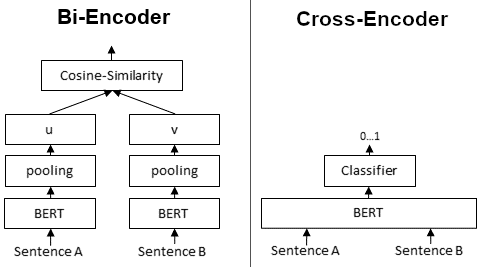

<br>

In [19]:
# !pip install sentence-transformers

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

# Initialise the cross encoder model
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")

In [20]:
# Test the cross encoder model

scores = cross_encoder.predict(
    [
        [
            "Which article empowers the president of India to appoint a Special Officer for Linguistic Minorities?",
            "Under Article 350B, a special officer for linguistic minorities has been enshrined in the constitution. This officer is to be appointed by the president. Its job is to investigate all matters relating to the safeguards provided for linguistic minorities and report to the president. Please note that this report is also one of those reports laid before each house of parliament and sent to the government of the states concerned.",
        ],
        [
            "In India, who has the authority to decide an election petition in India?",
            "Parliament has enacted Section 80-A of the Representation of the People Act, 1951 providing that the “High Court” shall be the authority for presentment of election petitions under Article 329(b) of the Constitution.",
        ],
    ]
)

scores

array([8.630359 , 3.4406548], dtype=float32)

##### Query #1

In [21]:
# Input (query, response) pairs for each of the top 10 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query_1, response] for response in results_df_1["Documents"]]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

# Store the rerank_scores in results_df
results_df_1["Reranked_scores"] = cross_rerank_scores
results_df_1

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,2693,Punishment for second and subsequent offences.,0.2641485631465912,"{'Element_Type': 'text', 'Legislation_Name': '...",0.229760
1,3807,other punishment,0.2311062067747116,"{'Page_No.': 'Page 4', 'Element_Serial_Order':...",-3.061434
2,2333,103. Punishment for murder.—(1) Whoever commit...,0.2611527740955353,"{'Element_Type': 'text', 'Element_Serial_Order...",8.868603
3,23797,A.—Death sentences,0.27109965682029724,{'Legislation_Name': 'Bharatiya_Nagarik_Suraks...,-2.622364
4,4628,109. Attempt to murder.—(1) Whoever does any a...,0.2107948660850525,"{'Page_No.': 'Page 45', 'Element_Serial_Order'...",6.258540
5,3806,103. Punishment for murder.,0.27783042192459106,"{'Legislation_Name': 'Income_Tax_Act_1961', 'P...",5.482667
6,4637,104. Punishment for murder by life-convict.—Wh...,0.29179054498672485,"{'Element_Serial_Order': 'Paragraph 5', 'Eleme...",7.615197
7,3805,105. Punishment for culpable homicide not amou...,0.2790866494178772,"{'Element_Type': 'text', 'Page_No.': 'Page 45'...",5.687849
8,4630,104. Punishment for murder by life-convict.,0.26444488763809204,"{'Element_Type': 'text', 'Legislation_Name': '...",5.060342
9,4631,105. Punishment for culpable homicide not amou...,0.28396621346473694,"{'Element_Type': 'text', 'Element_Serial_Order...",4.176521


In [22]:
# Top 3 results from the initial semantic search
top_3_semantic = results_df_1.sort_values(by="Distances")
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
4,4628,109. Attempt to murder.—(1) Whoever does any a...,0.2107948660850525,"{'Page_No.': 'Page 45', 'Element_Serial_Order'...",6.258540
1,3807,other punishment,0.2311062067747116,"{'Page_No.': 'Page 4', 'Element_Serial_Order':...",-3.061434
2,2333,103. Punishment for murder.—(1) Whoever commit...,0.2611527740955353,"{'Element_Type': 'text', 'Element_Serial_Order...",8.868603


In [23]:
# Top 3 results after applying Cross-encoder reranking model
top_3_rerank = results_df_1.sort_values(by="Reranked_scores", ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
2,2333,103. Punishment for murder.—(1) Whoever commit...,0.2611527740955353,"{'Element_Type': 'text', 'Element_Serial_Order...",8.868603
6,4637,104. Punishment for murder by life-convict.—Wh...,0.29179054498672485,"{'Element_Serial_Order': 'Paragraph 5', 'Eleme...",7.615197
4,4628,109. Attempt to murder.—(1) Whoever does any a...,0.2107948660850525,"{'Page_No.': 'Page 45', 'Element_Serial_Order'...",6.258540


In [24]:
# Extract only the "Documents" and "Metadatas" columns from the top 3 reranked results
# This is useful for RAG (Retrieval-Augmented Generation) tasks
query_1_top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
query_1_top_3_RAG

,Documents,Metadatas
2,103. Punishment for murder.—(1) Whoever commit...,"{'Element_Type': 'text', 'Element_Serial_Order..."
6,104. Punishment for murder by life-convict.—Wh...,"{'Element_Serial_Order': 'Paragraph 5', 'Eleme..."
4,109. Attempt to murder.—(1) Whoever does any a...,"{'Page_No.': 'Page 45', 'Element_Serial_Order'..."


In [25]:
def get_top_3_RAG(query, results_df):
    cross_inputs = [[query, response] for response in results_df["Documents"]]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)

    results_df["Reranked_scores"] = cross_rerank_scores
    top_3_rerank = results_df.sort_values(by="Reranked_scores", ascending=False)
    top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
    return top_3_RAG

##### Query #2

In [26]:
# Extract only the "Documents" and "Metadatas" columns from the top 3 reranked results
# This is useful for RAG (Retrieval-Augmented Generation) tasks
query_2_top_3_RAG = get_top_3_RAG(query_2, results_df_2)
query_2_top_3_RAG

,Documents,Metadatas
1,300. Suits and proceedings. CHAPTER IV. RIGHT...,"{'Element_Type': 'text', 'Element_Serial_Order..."
7,27. Extinguishment of right to property.,"{'Element_Type': 'text', 'Element_Serial_Order..."
2,"""property"" includes any interest in property, ...",{'Legislation_Name': 'Bharatiya_Nyaya_Sanhita_...


##### Query #3

In [27]:
# Extract only the "Documents" and "Metadatas" columns from the top 3 reranked results
# This is useful for RAG (Retrieval-Augmented Generation) tasks
query_3_top_3_RAG = get_top_3_RAG(query_3, results_df_3)
query_3_top_3_RAG

,Documents,Metadatas
4,Provided that in the case of any such person ...,"{'Page_No.': 'Page 75', 'Element_Type': 'text'..."
0,(3) The President of the National Appellate Au...,"{'Legislation_Name': 'Constitution_of_India', ..."
6,(b) the Chief Election Commissioner or an Elec...,"{'Element_Serial_Order': 'Paragraph 3', 'Eleme..."


#### 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 4o along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [28]:
# ===========================================================================================
# 30 SAMPLE QUERIES TO TEST
# ===========================================================================================

user_queries = [
    "What are the key features of the Bharatiya Nagarik Suraksha Sanhita, 2023?",
    "What changes does the Bharatiya Nyaya Sanhita, 2023 introduce in criminal law?",
    "How is electronic evidence treated under the Bharatiya Sakshya Adhiniyam, 2023?",
    "What is the procedure for filing a civil suit under the Code of Civil Procedure, 1908?",
    "What are the fundamental rights guaranteed by the Constitution of India?",
    "How is income from house property taxed under the Income Tax Act, 1961?",
    "What is the objective of the Direct Tax Vivad se Vishwas Act, 2020?",
    "What are the key provisions of the Central Goods and Services Tax Act, 2017?",
    "How does the GST Compensation to States Act, 2017 support state revenues?",
    "What are the rules for inter-state supply under the Integrated GST Act, 2017?",
    "What powers are given to police officers under the Police Act, 1949?",
    "What are the offences listed under the Unlawful Activities (Prevention) Act, 1967?",
    "How are prisoners transferred under the Prisoners Act, 1900?",
    "What are the bail provisions under Bharatiya Nagarik Suraksha Sanhita, 2023?",
    "What types of arms are prohibited under the Arms Act, 1959?",
    "What powers do authorities have under the Epidemic Diseases Act, 1897?",
    "When can quarantine be enforced according to Indian law?",
    "What are the essentials of a valid contract under the Indian Contract Act, 1872?",
    "Which documents are compulsorily registrable under the Registration Act, 1908?",
    "What are the consequences of a breach of contract under Indian law?",
    "How is delimitation of constituencies carried out under the Delimitation Act, 2002?",
    "What information can be accessed under the Right to Information Act, 2005?",
    "What are the exemptions under the RTI Act, 2005?",
    "How is the jurisdiction of Union Territories governed under the UT GST Act, 2017?",
    "What is the limitation period for filing a civil appeal under the Limitation Act, 1963?",
    "When does the limitation period begin according to Indian law?",
    "What is the difference between summary trial and warrant trial in Bharatiya Nyaya Sanhita?",
    "What are the evidentiary standards for digital records under Bharatiya Sakshya Adhiniyam, 2023?",
    "How are offences against women addressed in the Bharatiya Nyaya Sanhita, 2023?",
    "What is the process of arrest and detention as per Bharatiya Nagarik Suraksha Sanhita, 2023?",
]

In [ ]:
from openai import OpenAI

openai_client = OpenAI(api_key=OPENAI_API_KEY)


def generate_response(query, top_3_RAG):
    references = []
    for i, row in top_3_RAG.iterrows():
        meta = row["Metadatas"]
        references.append(f"{i+1}. [Source Info: {meta}]\n{row['Documents'].strip()}")
    references = "\n\n".join(references)

    messages = [
        {
            "role": "system",
            "content": (
                "You are a knowledgeable legal assistant specializing in Indian constitutional law and statutory interpretation. "
                "Your job is to provide accurate, well-reasoned, and easy-to-understand explanations based strictly on authoritative legal texts, "
                "such as the Constitution of India, central legislations, and landmark court rulings."
            ),
        },
        {
            "role": "user",
            "content": (
                f'I have a legal question: "{query}"\n\n'
                "Please use only the following retrieved legal references to answer the query. "
                "Your answer should:\n"
                "- Be grounded in the content of these documents\n"
                "- Be concise, clear, and in plain language (unless legal terminology is required)\n"
                "- Mention the specific articles/sections/case laws used, when relevant\n\n"
                "### Retrieved References:\n"
                f"{references}"
            ),
        },
    ]

    response = openai_client.responses.create(
        model="gpt-4o", input=messages, temperature=0.5, store=True
    )
    return response.output_text

In [32]:
import random
import time

# Get User Query
# query = input()

# OR Choose a random query from the list
query = random.choice(user_queries)
print("User: ", query, "\n")

results_df = semantic_search(query)
top_3_RAG = get_top_3_RAG(query, results_df)
response = generate_response(query, top_3_RAG)

print("Assistant: ", response)

User:  How is delimitation of constituencies carried out under the Delimitation Act, 2002? 

Found in cache!
Assistant:  Under the Delimitation Act, 2002, the process of delimitation of constituencies is carried out by the Delimitation Commission. Here's a concise explanation based on the retrieved references:

1. **Distribution and Delimitation**: According to the Act, the Delimitation Commission is responsible for distributing seats in the House of the People (Lok Sabha) and the Legislative Assemblies of each State. This distribution is based on the 1971 census figures, updated with data from the 2001 census. The Commission must ensure that these constituencies are single-member territorial constituencies. This process is detailed in Paragraph 9 of the Act (Page 6).

2. **Legal Effect in Jharkhand**: There is a specific provision regarding the State of Jharkhand, where the orders related to the delimitation published in 2007 have no legal effect. Instead, the delimitation as it exist

In [33]:
query = random.choice(user_queries)
print("User: ", query, "\n")

time.sleep(10)
results_df = semantic_search(query)
top_3_RAG = get_top_3_RAG(query, results_df)
response = generate_response(query, top_3_RAG)

print("Assistant: ", response)
time.sleep(10)

User:  How does the GST Compensation to States Act, 2017 support state revenues? 

Not found in cache. Found in main collection.
Assistant:  The Goods and Services Tax (Compensation to States) Act, 2017, was enacted to support state revenues by providing them with compensation for any loss of revenue arising from the implementation of the Goods and Services Tax (GST). Here’s how it works:

1. **Objective**: The primary goal of the Act is to ensure that states are not financially disadvantaged by the shift to the GST system, which replaced various state and central taxes.

2. **Compensation Mechanism**: The Act provides a framework for compensating states for any revenue shortfall. This is calculated based on the projected growth rate of state revenues, which was assumed to be 14% per annum from the base year 2015-16.

3. **Cess Collection**: To fund this compensation, a GST compensation cess is levied on certain luxury and sin goods. The revenue collected from this cess is distributed 

In [34]:
query = random.choice(user_queries)
print("User: ", query, "\n")

time.sleep(10)
results_df = semantic_search(query)
top_3_RAG = get_top_3_RAG(query, results_df)
response = generate_response(query, top_3_RAG)

print("Assistant: ", response)

User:  When does the limitation period begin according to Indian law? 

Found in cache!
Assistant:  The Limitation Act, 1963, governs the rules for the limitation period in India. According to this Act, the limitation period generally begins when the right to sue accrues. This means the countdown starts from the moment a legal right is violated or when a specific event that triggers the legal claim occurs.

The retrieved references primarily discuss transitional provisions related to the shift from the Indian Limitation Act, 1908, to the Limitation Act, 1963. Specifically, they mention how certain suits, appeals, or applications could be made within a specific timeframe after the commencement of the new Act, especially when the limitation period was shorter under the previous Act (The Limitation Act, 1908).

For example, if the limitation period under the 1908 Act was shorter than under the 1963 Act, appeals or applications could be made within 90 days after the 1963 Act commenced or w